In [1]:
# Import libraries 
import xarray as xr
import geopandas as gpd
from shapely.geometry import mapping
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.interpolate import griddata

In [2]:
# Import dataset
df = xr.open_dataset(r'D_Max_HLI.nc')

In [3]:
# Change dataset into a pandas dataframe
D_Max_HLI = df.to_dataframe()
D_Max_HLI

,latitude,longitude,province_name,time,HLI
index,,,,,
0,-21.0,166.0,None,1994-01-01,89.936264
1,-21.0,166.0,None,1994-01-02,92.363518
2,-21.0,166.0,None,1994-01-03,96.083809
3,-21.0,166.0,None,1994-01-04,91.725319
4,-21.0,166.0,None,1994-01-05,88.079987
...,...,...,...,...,...
7593889,-13.0,171.0,None,2023-12-28,92.107323
7593890,-13.0,171.0,None,2023-12-29,93.660080
7593891,-13.0,171.0,None,2023-12-30,93.186668


In [4]:
# Remove oceanic data
D_Max_HLI = D_Max_HLI[(D_Max_HLI['province_name'] != 'None')]
D_Max_HLI

,latitude,longitude,province_name,time,HLI
index,,,,,
854724,-20.25,169.75,Tafea,1994-01-01,89.964661
854725,-20.25,169.75,Tafea,1994-01-02,89.905556
854726,-20.25,169.75,Tafea,1994-01-03,88.427795
854727,-20.25,169.75,Tafea,1994-01-04,90.409126
854728,-20.25,169.75,Tafea,1994-01-05,91.623009
...,...,...,...,...,...
7396645,-13.00,166.50,Torba,2023-12-28,91.277702
7396646,-13.00,166.50,Torba,2023-12-29,94.825279
7396647,-13.00,166.50,Torba,2023-12-30,93.482803


In [ ]:
# AVERAGE NUMBER OF HOT DAYS 1994-2023

In [5]:
# Calculate the average number of 'hot' days per tropical cyclone year for each raster cell

# Reset the index to make 'time' a column, if not already done
D_Max_HLI = D_Max_HLI.reset_index()

# Convert 'time' to datetime format
D_Max_HLI['time'] = pd.to_datetime(D_Max_HLI['time'])

# Define fiscal year based on July-June cycle
def get_fiscal_year(date):
    return date.year if date.month >= 7 else date.year - 1

# Apply fiscal year calculation
D_Max_HLI['fiscal_year'] = D_Max_HLI['time'].apply(get_fiscal_year)

# Define HLI threshold
threshold = 93

# Create a boolean mask for HLI above the threshold
mask = D_Max_HLI['HLI'] >= threshold

# Filter the dataset based on the mask
filtered_D_Max_HLI = D_Max_HLI[mask]

# Group by fiscal year and raster cell (latitude, longitude), then count days above threshold
annual_counts = (
    filtered_D_Max_HLI
    .groupby(['fiscal_year', 'latitude', 'longitude'])
    .size()
    .reset_index(name='days_above_threshold')
)

# Calculate the average number of days above threshold per fiscal year for each raster cell
average_days = (
    annual_counts
    .groupby(['latitude', 'longitude'])['days_above_threshold']
    .mean()
    .reset_index(name='average_days_above_threshold')
)

# Display the results
average_days

,latitude,longitude,average_days_above_threshold
0,-20.25,169.75,20.032258
1,-20.25,170.00,20.612903
2,-19.75,169.25,29.935484
3,-19.75,169.50,29.483871
4,-19.50,169.25,57.709677
...,...,...,...
69,-13.50,167.50,79.354839
70,-13.25,166.50,78.935484
71,-13.25,166.75,81.870968
72,-13.25,167.75,87.516129


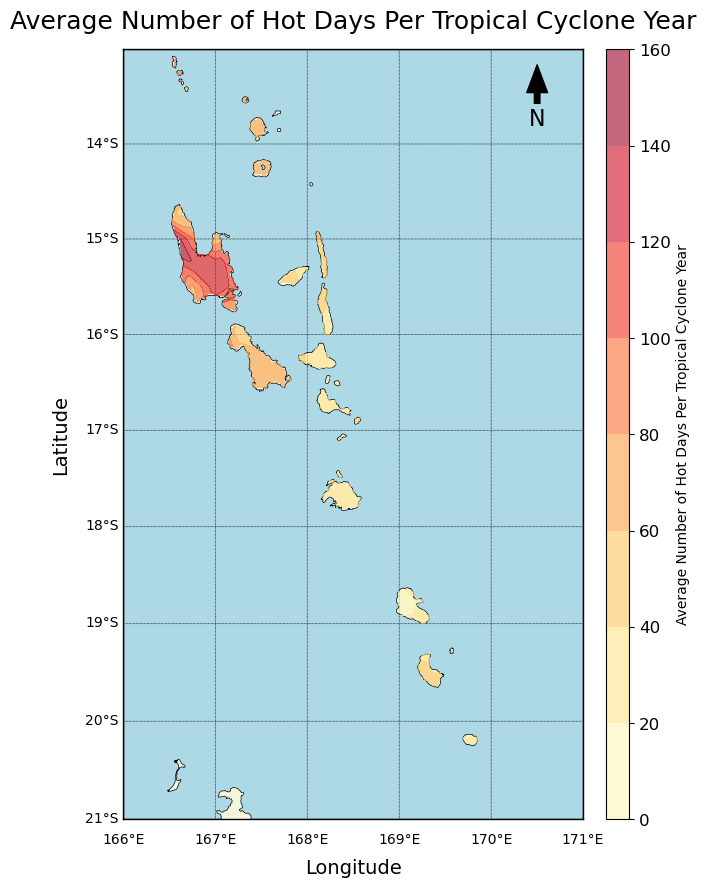

In [28]:
# Draw heatmap

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Create a Basemap instance
m = Basemap(projection='merc',
            llcrnrlat=-21, urcrnrlat=-13,
            llcrnrlon=166, urcrnrlon=171,
            resolution='h', ax=ax)

# Draw map details
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='beige', lake_color='lightblue')

# Convert latitude and longitude to map projection
x, y = m(average_days['longitude'].values, average_days['latitude'].values)

# Create a grid for the contour plot
lon_grid = np.linspace(166, 171, 300)  # Increased resolution
lat_grid = np.linspace(-21, -13, 300)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Interpolate average_days values onto the grid using griddata
av_hot_days_grid = griddata(
    (average_days['longitude'].values, average_days['latitude'].values), 
    average_days['average_days_above_threshold'].values, 
    (lon_grid, lat_grid), method='linear'
)

# Convert grid lat/lon to map coordinates
x_grid, y_grid = m(lon_grid, lat_grid)

# Mask ocean areas using maskoceans
av_hot_days_masked = maskoceans(
    lon_grid, lat_grid, av_hot_days_grid, resolution='h', grid=1.25, 
    inlands=True
)

# Contour plot restricted to the island borders
contour = m.contourf(x_grid, y_grid, av_hot_days_masked, cmap='YlOrRd', alpha=0.6, zorder=10)

# Add color bar
cbar = m.colorbar(contour, location='right', pad='5%')
cbar.set_label('Average Number of Hot Days Per Tropical Cyclone Year')
cbar.ax.tick_params(labelsize=12)

# Add title
plt.title('Average Number of Hot Days Per Tropical Cyclone Year', fontsize=18, pad=15)  # Adjust fontsize and padding

# Draw latitude and longitude lines with labels
parallels = np.arange(-21, -12, 1)  # Adjust range and spacing as needed
meridians = np.arange(166, 172, 1)  # Adjust range and spacing as needed

# Add gridlines
m.drawparallels(parallels, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)
m.drawmeridians(meridians, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)

# Add North arrow
plt.annotate('', xy=(0.9, 0.98), xytext=(0.9, 0.93),
             arrowprops=dict(facecolor='black', edgecolor='black', headwidth=15, headlength=20, width=4),
             ha='center', va='center', xycoords='axes fraction')

# Add the "N" label below the arrow
plt.text(0.9, 0.91, 'N', fontsize=16, ha='center', va='center', transform=ax.transAxes)
    
# Add axis labels
plt.xlabel('Longitude', fontsize=14, labelpad= 25)
plt.ylabel('Latitude', fontsize=14, labelpad= 35)

# Save the figure
plt.savefig('map_vanuatu_hot_days.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# AVERAGE SEVERITY OF HOT DAYS 1994-2023

In [30]:
# Calculate the severity (difference between threshold and actual HLI)
filtered_D_Max_HLI.loc[:, 'severity'] = filtered_D_Max_HLI['HLI'] - 93

# Calculate the mean severity for each grid cell over 30 year period
mean_severity = filtered_D_Max_HLI.groupby(['latitude', 'longitude', 'province_name'])['severity'].mean().reset_index()

# Rename columns for clarity if needed
mean_severity.rename(columns={'severity': 'mean_severity'}, inplace=True)

# Display the result
mean_severity

,latitude,longitude,province_name,mean_severity
0,-20.25,169.75,Tafea,2.319770
1,-20.25,170.00,Tafea,2.347746
2,-19.75,169.25,Tafea,2.531101
3,-19.75,169.50,Tafea,2.398998
4,-19.50,169.25,Tafea,2.610591
...,...,...,...,...
69,-13.50,167.50,Torba,2.229785
70,-13.25,166.50,Torba,2.314041
71,-13.25,166.75,Torba,2.282542
72,-13.25,167.75,Torba,2.297365


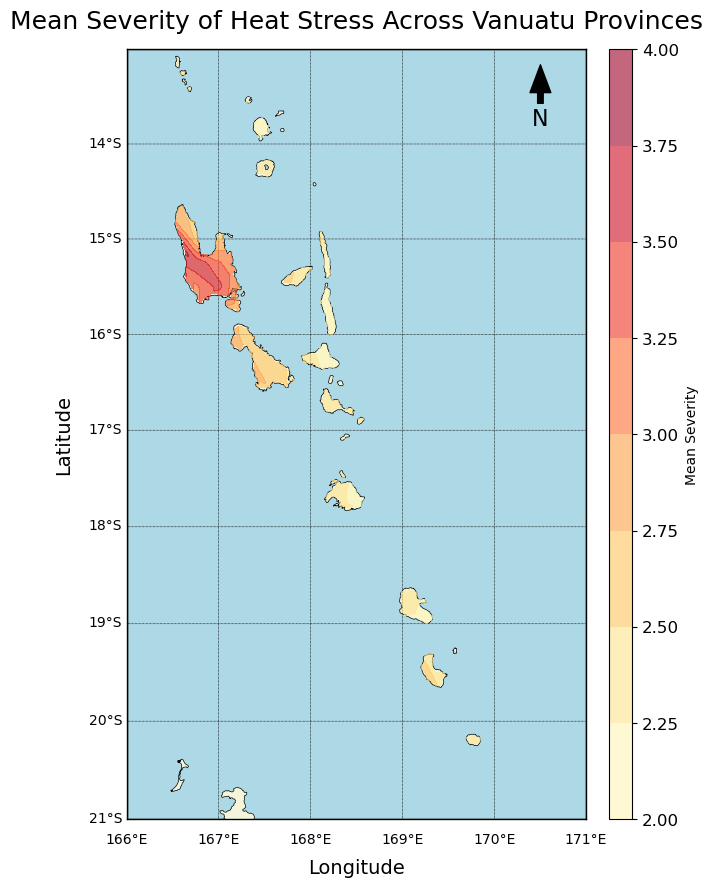

In [32]:
# Plot severity heatmap

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Create a Basemap instance
m = Basemap(projection='merc',
            llcrnrlat=-21, urcrnrlat=-13,
            llcrnrlon=166, urcrnrlon=171,
            resolution='h', ax=ax)

# Draw map details
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='beige', lake_color='lightblue')

# Convert latitude and longitude to map projection
x, y = m(mean_severity['longitude'].values, mean_severity['latitude'].values)

# Create a grid for the contour plot
lon_grid = np.linspace(166, 171, 300)  # Increased resolution
lat_grid = np.linspace(-21, -13, 300)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Interpolate mean_severity values onto the grid using griddata
mean_severity_grid = griddata(
    (mean_severity['longitude'].values, mean_severity['latitude'].values), 
    mean_severity['mean_severity'].values, 
    (lon_grid, lat_grid), method='linear'
)

# Convert grid lat/lon to map coordinates
x_grid, y_grid = m(lon_grid, lat_grid)

# Mask ocean areas using maskoceans
mean_severity_grid_masked = maskoceans(
    lon_grid, lat_grid, mean_severity_grid, resolution='h', grid=1.25, 
    inlands=True
)

# Contour plot restricted to the island borders
contour = m.contourf(x_grid, y_grid, mean_severity_grid_masked, cmap='YlOrRd', alpha=0.6, zorder=10)

# Add color bar
cbar = m.colorbar(contour, location='right', pad='5%')
cbar.set_label('Mean Severity')
cbar.ax.tick_params(labelsize=12)  # Increase font size for colorbar

# Draw latitude and longitude lines with labels
parallels = np.arange(-21, -12, 1)  # Adjust range and spacing as needed
meridians = np.arange(166, 172, 1)  # Adjust range and spacing as needed

# Add gridlines
m.drawparallels(parallels, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)
m.drawmeridians(meridians, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)

# Add North arrow
plt.annotate('', xy=(0.9, 0.98), xytext=(0.9, 0.93),
             arrowprops=dict(facecolor='black', edgecolor='black', headwidth=15, headlength=20, width=4),
             ha='center', va='center', xycoords='axes fraction')

# Add the "N" label below the arrow
plt.text(0.9, 0.91, 'N', fontsize=16, ha='center', va='center', transform=ax.transAxes)
    
# Add axis labels
plt.xlabel('Longitude', fontsize=14, labelpad= 25)
plt.ylabel('Latitude', fontsize=14, labelpad= 35)

# Add title
plt.title('Mean Severity of Heat Stress Across Vanuatu Provinces', fontsize=18, pad=15)  # Adjust fontsize and padding

# Save the figure
plt.savefig('Mean_Severity.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# AVERAGE NUMBER OF HOT DAYS IN WET VS DRY SEASON 1994-2023

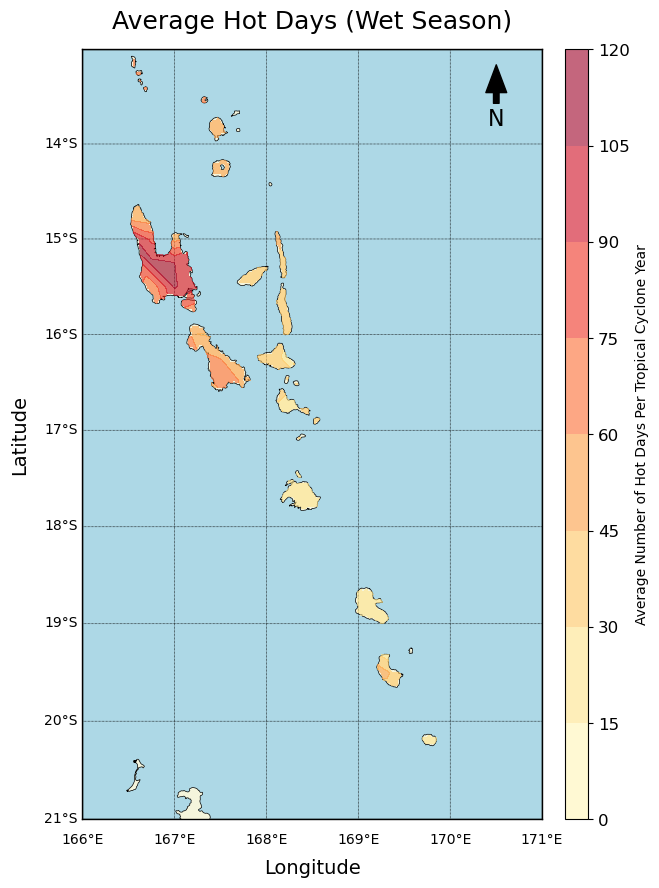

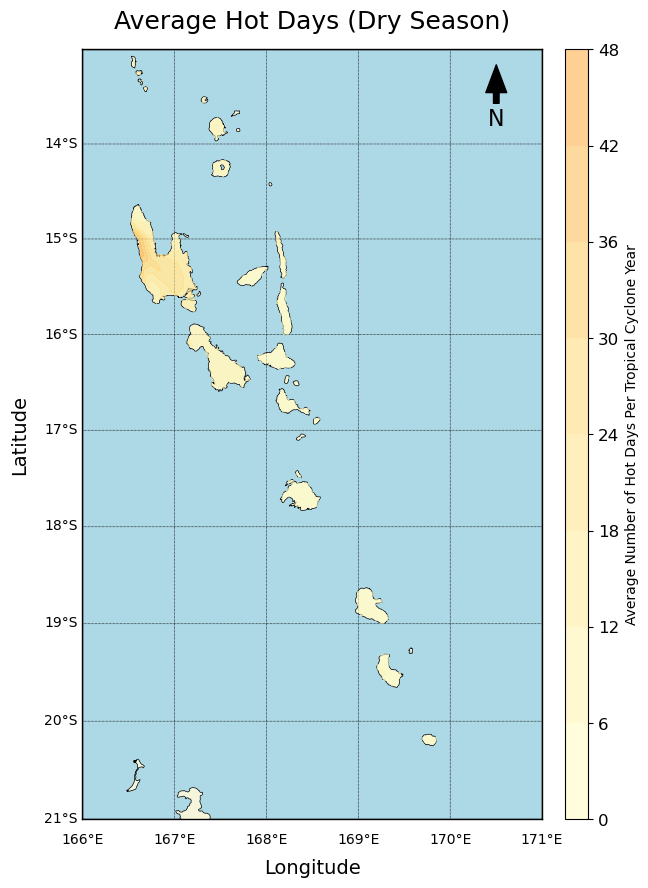

In [39]:
# Define function to categorize wet or dry season
def categorize_season(date):
    if date.month in [11, 12, 1, 2, 3, 4]:  # November to April
        return 'wet'
    else:  # May to October
        return 'dry'

# Add season category to the dataset
D_Max_HLI['season'] = D_Max_HLI['time'].apply(categorize_season)

# Define function to calculate average days above threshold for each dataset
def calculate_average_days_above_threshold(D_Max_HLI):
    D_Max_HLI = D_Max_HLI.reset_index(drop=True)  # Use drop=True to avoid index issues
    D_Max_HLI['time'] = pd.to_datetime(D_Max_HLI['time'])
    D_Max_HLI['fiscal_year'] = D_Max_HLI['time'].apply(lambda date: date.year if date.month >= 7 else date.year - 1)

    threshold = 93
    mask = D_Max_HLI['HLI'] >= threshold
    filtered_D_Max_HLI = D_Max_HLI[mask]

    annual_counts = (
        filtered_D_Max_HLI
        .groupby(['fiscal_year', 'latitude', 'longitude'])
        .size()
        .reset_index(name='days_above_threshold')
    )

    average_days = (
        annual_counts
        .groupby(['latitude', 'longitude'])['days_above_threshold']
        .mean()
        .reset_index(name='average_days_above_threshold')
    )

    return average_days

# Define function to plot the map
def plot_average_days_map(average_days, title, filename, vmin, vmax):
    fig, ax = plt.subplots(figsize=(12, 10))
    m = Basemap(projection='merc',
                llcrnrlat=-21, urcrnrlat=-13,
                llcrnrlon=166, urcrnrlon=171,
                resolution='h', ax=ax)
    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=1)
    m.drawmapboundary(fill_color='lightblue')
    m.fillcontinents(color='beige', lake_color='lightblue')

    x, y = m(average_days['longitude'].values, average_days['latitude'].values)

    # Create a grid for the contour plot
    lon_grid = np.linspace(166, 171, 300)  # Increased resolution
    lat_grid = np.linspace(-21, -13, 300)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    av_hot_days_grid = griddata(
        (average_days['longitude'].values, average_days['latitude'].values), 
        average_days['average_days_above_threshold'].values, 
        (lon_grid, lat_grid), method='linear'
    )

    x_grid, y_grid = m(lon_grid, lat_grid)

    av_hot_days_masked = maskoceans(
        lon_grid, lat_grid, av_hot_days_grid, resolution='h', grid=1.25, 
        inlands = True
    )

    contour = m.contourf(x_grid, y_grid, av_hot_days_masked, cmap='YlOrRd', alpha=0.6, zorder=10, vmin=vmin, vmax=vmax)

    cbar = m.colorbar(contour, location='right', pad='5%')
    cbar.set_label('Average Number of Hot Days Per Tropical Cyclone Year')
    cbar.ax.tick_params(labelsize=12)

    plt.title(title, fontsize=18, pad=15)

    # Draw latitude and longitude lines with labels
    parallels = np.arange(-21, -12, 1)  # Adjust range and spacing as needed
    meridians = np.arange(166, 172, 1)  # Adjust range and spacing as needed

    # Add gridlines
    m.drawparallels(parallels, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)
    m.drawmeridians(meridians, labels=[1,0,0,1], fontsize=10, color='black', linewidth=0.5)

    # Add North arrow
    plt.annotate('', xy=(0.9, 0.98), xytext=(0.9, 0.93),
             arrowprops=dict(facecolor='black', edgecolor='black', headwidth=15, headlength=20, width=4),
             ha='center', va='center', xycoords='axes fraction')

    # Add the "N" label below the arrow
    plt.text(0.9, 0.91, 'N', fontsize=16, ha='center', va='center', transform=ax.transAxes)
    
    # Add axis labels
    plt.xlabel('Longitude', fontsize=14, labelpad= 25)
    plt.ylabel('Latitude', fontsize=14, labelpad= 35)

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Split datasets by decade and season
D_Max_HLI_wet = D_Max_HLI[(D_Max_HLI['time'].dt.year >= 1994) & (D_Max_HLI['time'].dt.year <= 2023) & (D_Max_HLI['season'] == 'wet')]
D_Max_HLI_dry = D_Max_HLI[(D_Max_HLI['time'].dt.year >= 1994) & (D_Max_HLI['time'].dt.year <= 2023) & (D_Max_HLI['season'] == 'dry')]

# Calculate average days above threshold for each subset
average_days_D_Max_HLI_wet = calculate_average_days_above_threshold(D_Max_HLI_wet)
average_days_D_Max_HLI_dry = calculate_average_days_above_threshold(D_Max_HLI_dry)

# Combine all datasets to find the overall range for colorbar
combined_average_days = pd.concat([
    average_days_D_Max_HLI_wet,
    average_days_D_Max_HLI_dry
])

# Get colorbar limits
vmin = 0
vmax = 120

# Plot maps for each subset with consistent colorbar
plot_average_days_map(
    average_days_D_Max_HLI_wet, 
    'Average Hot Days (Wet Season)', 
    'map_vanuatu_hot_days_wet.png',
    vmin, vmax
)

plot_average_days_map(
    average_days_D_Max_HLI_dry, 
    'Average Hot Days (Dry Season)', 
    'map_vanuatu_hot_days_dry.png',
    vmin, vmax
)